# 실습1: 약물구조데이터 + 부작용데이터를 활용한 약물-부작용 예측
## 참고자료
- DrugBank (https://www.drugbank.ca/)
- RDKit 문서 (https://www.rdkit.org/docs/)
- Scikit-learn 문서 (https://scikit-learn.org/)

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 48.7 MB/s eta 0:00:00


In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings('ignore')

# 랜덤 시드 설정
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


# 실습1: 약물 구조 데이터 + 부작용 데이터를 활용한 약물-부작용 예측

http://sideeffects.embl.de/

https://go.drugbank.com/releases/latest#structures

In [ ]:
# 파일 다운로드
!wget http://sideeffects.embl.de/media/download/drug_names.tsv
!wget http://sideeffects.embl.de/media/download/meddra_all_se.tsv.gz
!wget http://sideeffects.embl.de/media/download/meddra.tsv.gz

# 압축 풀기
!gunzip *.gz

--2024-12-07 06:24:41--  http://sideeffects.embl.de/media/download/drug_names.tsv
Resolving sideeffects.embl.de (sideeffects.embl.de)... 194.94.44.34
Connecting to sideeffects.embl.de (sideeffects.embl.de)|194.94.44.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34759 (34K) [text/tab-separated-values]
Saving to: ‘drug_names.tsv’

drug_names.tsv      100%[===================>]  33.94K   170KB/s    in 0.2s    

2024-12-07 06:24:41 (170 KB/s) - ‘drug_names.tsv’ saved [34759/34759]

--2024-12-07 06:24:41--  http://sideeffects.embl.de/media/download/meddra_all_se.tsv.gz
Resolving sideeffects.embl.de (sideeffects.embl.de)... 194.94.44.34
Connecting to sideeffects.embl.de (sideeffects.embl.de)|194.94.44.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2381171 (2.3M) [application/x-gzip]
Saving to: ‘meddra_all_se.tsv.gz’

meddra_all_se.tsv.g 100%[===================>]   2.27M  1.37MB/s    in 1.7s    

2024-12-07 06:24:43 (1.37 MB/s) - ‘me

In [ ]:
# 데이터 로드
drug_names = pd.read_csv('drug_names.tsv', sep='\t',
                        names=['compound_id', 'drug_name'])
side_effects = pd.read_csv('meddra_all_se.tsv', sep='\t',
                          names=['compound_id', 'side_effect_id',
                                'side_effect_name'])
meddra = pd.read_csv('meddra.tsv', sep='\t',
                     names=['side_effect_id', 'side_effect_name'])

In [ ]:
drug_names

,compound_id,drug_name
0,CID100000085,carnitine
1,CID100000119,gamma-aminobutyric
2,CID100000137,5-aminolevulinic
3,CID100000143,leucovorin
4,CID100000146,5-methyltetrahydrofolate
...,...,...
1425,CID156603655,pegaptanib
1426,CID156842239,n-3
1427,CID170683024,x
1428,CID170695640,colestyramine


In [ ]:
side_effects

compound_id side_effect_id  \
CID100000085 CID000010917 C0000729         LLT       C0000729   
                          C0000729          PT       C0000737   
                          C0000737         LLT       C0000737   
                          C0000737          PT       C0687713   
                          C0000737          PT       C0000737   
...                                        ...            ...   
CID171306834 CID071306834 C3203358          PT       C1145670   
                          C3665386         LLT       C3665386   
                          C3665386          PT       C3665347   
                          C3665596         LLT       C3665596   
                          C3665596          PT       C0347390   

                                         side_effect_name  
CID100000085 CID000010917 C0000729       Abdominal cramps  
                          C0000729         Abdominal pain  
                          C0000737         Abdominal pain  
                          C0000737  Gastrointestinal pain  
                          C0000737         Abdominal pain  
...                                                   ...  
CID171306834 CID071306834 C3203358    Respiratory failure  
                          C3665386        Abnormal vision  
                          C3665386      Visual impairment  
                          C3665596                  Warts  
                          C3665596         Skin papilloma  

[309849 rows x 3 columns]

In [ ]:
meddra

side_effect_id             side_effect_name
C0000727 LT        10000647                Acute abdomen
         PT        10000647                Acute abdomen
         LT        10042784     Syndrome abdominal acute
         LT        10000096     Abdominal syndrome acute
C0000729 LT        10000057             Abdominal cramps
...                     ...                          ...
C3666015 LT        10074155  Device material degradation
C3666016 LT        10074210         Coarse breath sounds
C3666017 LT        10074226               Cholangiopathy
C3666018 LT        10074267      Spontaneous ejaculation
         PT        10074267      Spontaneous ejaculation

[95912 rows x 2 columns]

In [ ]:
# side_effects의 side_effect_name 고유값 개수
side_effects['side_effect_name'].nunique()

6123

In [ ]:
# side_effects의 compound_id가 PT인 데이터 중 고유한 side_effect_name 개수
side_effects[side_effects['compound_id']=='PT']['side_effect_name'].nunique()

4251

In [ ]:
# side_effects의 side_effect_name 상위 20개 추출
side_effects['side_effect_name'].value_counts().head(20)

,count
side_effect_name,
Dizziness,2826
Nausea,2601
Headache,2416
Rash,2403
Vomiting,2345
Asthenia,2264
Diarrhoea,2200
Pruritus,2049
Hypersensitivity,1952


In [ ]:
# 상위 3개에 해당하는 side_effect_name 저장
top_side_effects = side_effects['side_effect_name'].value_counts().head(3).index.tolist()
top_side_effects

['Dizziness', 'Nausea', 'Headache']

In [ ]:
# side_effects의 compound_id가 PT인 데이터만 필터링
sample_side_effects = side_effects[side_effects['compound_id']=='PT']
# top_side_effects에 해당하는 side_effect_name만 필터링
sample_side_effects = sample_side_effects[sample_side_effects['side_effect_name'].isin(top_side_effects)]
sample_side_effects

compound_id side_effect_id side_effect_name
CID100000085 CID000010917 C0012833          PT       C0012833        Dizziness
                          C0018681          PT       C0018681         Headache
                          C0027497          PT       C0027497           Nausea
CID100000137 CID000000137 C0018681          PT       C0018681         Headache
                          C0027497          PT       C0027497           Nausea
...                                        ...            ...              ...
CID170695640 CID070695640 C0039070          PT       C0012833        Dizziness
CID171306834 CID071306834 C0012833          PT       C0012833        Dizziness
                          C0018681          PT       C0018681         Headache
                          C0027497          PT       C0027497           Nausea
                          C0039070          PT       C0012833        Dizziness

[4279 rows x 3 columns]

In [ ]:
# 200개 무작위 선택 후 인덱스 재설정
sample_side_effects = sample_side_effects.sample(n=200, random_state=RANDOM_SEED)
sample_side_effects.reset_index(drop=False, inplace=True)
sample_side_effects.drop(columns=['level_1', 'level_2'], inplace=True)
sample_side_effects

,level_0,compound_id,side_effect_id,side_effect_name
0,CID100003639,PT,C0018681,Headache
1,CID100005505,PT,C0027497,Nausea
2,CID116137271,PT,C0012833,Dizziness
3,CID110182969,PT,C0012833,Dizziness
4,CID106850791,PT,C0018681,Headache
...,...,...,...,...
195,CID100002727,PT,C0018681,Headache
196,CID100004763,PT,C0012833,Dizziness
197,CID100004139,PT,C0027497,Nausea
198,CID100003730,PT,C0012833,Dizziness


In [ ]:
# compound_id 컬럼을 삭제하고, level_0 컬럼을 compound_id로 변환
sample_side_effects['compound_id'] = sample_side_effects['level_0']
sample_side_effects.drop(columns=['level_0'], inplace=True)
sample_side_effects.reset_index(drop=True, inplace=True)
sample_side_effects

,compound_id,side_effect_id,side_effect_name
0,CID100003639,C0018681,Headache
1,CID100005505,C0027497,Nausea
2,CID116137271,C0012833,Dizziness
3,CID110182969,C0012833,Dizziness
4,CID106850791,C0018681,Headache
...,...,...,...
195,CID100002727,C0018681,Headache
196,CID100004763,C0012833,Dizziness
197,CID100004139,C0027497,Nausea
198,CID100003730,C0012833,Dizziness


In [ ]:
drug_names

,compound_id,drug_name
0,CID100000085,carnitine
1,CID100000119,gamma-aminobutyric
2,CID100000137,5-aminolevulinic
3,CID100000143,leucovorin
4,CID100000146,5-methyltetrahydrofolate
...,...,...
1425,CID156603655,pegaptanib
1426,CID156842239,n-3
1427,CID170683024,x
1428,CID170695640,colestyramine


In [ ]:
# side_effect_name 별 데이터 개수 계산
sample_side_effects['side_effect_name'].value_counts()

,count
side_effect_name,
Dizziness,80
Nausea,67
Headache,53


In [ ]:
# 샘플링한 부작용 데이터에서 약물 아이디를 약물 이름으로 변환
sample_side_effects = sample_side_effects.merge(drug_names, on='compound_id', how='left')
sample_side_effects

,compound_id,side_effect_id,side_effect_name,drug_name
0,CID100003639,C0018681,Headache,hydrochlorothiazide
1,CID100005505,C0027497,Nausea,tolbutamide
2,CID116137271,C0012833,Dizziness,insulin
3,CID110182969,C0012833,Dizziness,apixaban
4,CID106850791,C0018681,Headache,leuprorelin
...,...,...,...,...
195,CID100002727,C0018681,Headache,chlorpropamide
196,CID100004763,C0012833,Dizziness,phenobarbital
197,CID100004139,C0027497,Nausea,methylene
198,CID100003730,C0012833,Dizziness,iohexol


In [ ]:
# 고유한 약물 이름 개수
sample_side_effects['drug_name'].nunique()

188

In [ ]:
drug_names = set(sample_side_effects['drug_name'])
drug_names

{'4-PBA',
 '5-ASA',
 'Azarga',
 'DFMO',
 'FK463',
 'FP-CIT',
 'Fe(III',
 'Gd-DTPA',
 'Hoe',
 'Lutalyse',
 'Nafarelin',
 'Romidepsin',
 'SOM230',
 'Signifor',
 'Supremon',
 'Symlin',
 'Terlipressin',
 'Triptorelin',
 'amifostine',
 'amitriptyline',
 'amlodipine',
 'amoxapine',
 'amsacrine',
 'anthracycline',
 'apixaban',
 'arsenic',
 'azelastine',
 'balsalazide',
 'barium',
 'benzydamine',
 'bisacodyl',
 'bisoprolol',
 'bortezomib',
 'bromocriptine',
 'budesonide',
 'cabozantinib',
 'candesartan',
 'carbamazepine',
 'carbenicillin',
 'carbidopa',
 'carbimazole',
 'carboprost',
 'cefixime',
 'ceftaroline',
 'cefuroxime',
 'cetirizine',
 'chlorpropamide',
 'cinacalcet',
 'ciprofloxacin',
 'citalopram',
 'clonidine',
 'codeine',
 'cyclophosphamide',
 'dabrafenib',
 'dapagliflozin',
 'demeclocycline',
 'desipramine',
 'desvenlafaxine',
 'dexrazoxane',
 'dextrorphan',
 'diatrizoate',
 'diazepam',
 'dicyclomine',
 'didanosine',
 'diethylenetriaminepentaacetic',
 'diethylpropion',
 'diltiazem'

In [ ]:
from urllib.request import urlopen
from urllib.parse import quote

def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'

def get_drug_smiles(drug_names):
    drug_smiles_dict = {}

    for drug in drug_names:
        if drug and isinstance(drug, str):  # None이나 빈 문자열이 아닌 경우만 처리
            try:
                smiles = CIRconvert(drug)
                if smiles != 'Did not work':
                    drug_smiles_dict[drug] = smiles
                    print(f"성공: {drug} -> {smiles}")
                else:
                    print(f"실패: {drug}")
            except Exception as e:
                print(f"오류 발생 ({drug}): {str(e)}")
                continue

    return drug_smiles_dict

# 변환 실행
drug_smiles_dict = get_drug_smiles(drug_names)

# 결과 데이터프레임으로 변환
smiles_df = pd.DataFrame(list(drug_smiles_dict.items()),
                        columns=['drug_name', 'SMILES'])

성공: pimozide -> Fc1ccc(cc1)C(CCCN2CCC(CC2)N3C(=O)Nc4ccccc34)c5ccc(F)cc5
성공: metolazone -> CC1Nc2cc(Cl)c(cc2C(=O)N1c3ccccc3C)[S](N)(=O)=O
성공: finasteride -> CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(=O)C=C[C@]4(C)[C@H]3CC[C@]12C
성공: cyclophosphamide -> ClCCN(CCCl)[P]1(=O)NCCCO1
성공: moxonidine -> COc1nc(C)nc(Cl)c1NC2=NCCN2
성공: Romidepsin -> C/C=C/1NC(=O)[C@H]2CSSCC/C=C/[C@H](CC(=O)N[C@H](C(C)C)C(=O)N2)OC(=O)[C@@H](NC1=O)C(C)C
실패: retinoic
성공: pravastatin -> CC[C@H](C)C(=O)O[C@H]1C[C@H](O)C=C2C=C[C@H](C)[C@H](CC[C@@H](O)C[C@@H](O)CC(O)=O)[C@@H]12
실패: poly(styrene
성공: diethylpropion -> CCN(CC)C(C)C(=O)c1ccccc1
성공: timolol -> CC(C)(C)NC[C@H](O)COc1nsnc1N2CCOCC2
성공: thiamine -> [Cl-].Cc1ncc(C[n+]2csc(CCO)c2C)c(N)n1
성공: iodide -> [I-]
성공: rimantadine -> CC(N)C12CC3CC(CC(C3)C1)C2
성공: amitriptyline -> CN(C)CCC=C1c2ccccc2CCc3ccccc13
성공: dextrorphan -> CN1CC[C@@]23CCCC[C@@H]2[C@@H]1Cc4ccc(O)cc34
성공: doripenem -> C[C@@H](O)[C@@H]1[C@H]2[C@@H](C)C(=C(N2C1=O)C(O)=O)S[C@@H]3CN[C@H](CN[S](N)(=O)=O

In [ ]:
smiles_df

,drug_name,SMILES
0,pimozide,Fc1ccc(cc1)C(CCCN2CCC(CC2)N3C(=O)Nc4ccccc34)c5...
1,metolazone,CC1Nc2cc(Cl)c(cc2C(=O)N1c3ccccc3C)[S](N)(=O)=O
2,finasteride,CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(...
3,cyclophosphamide,ClCCN(CCCl)[P]1(=O)NCCCO1
4,moxonidine,COc1nc(C)nc(Cl)c1NC2=NCCN2
...,...,...
156,phenobarbital,CCC1(C(=O)NC(=O)NC1=O)c2ccccc2
157,nitroglycerin,[O-][N+](=O)OCC(CO[N+]([O-])=O)O[N+]([O-])=O
158,salbutamol,CC(C)(C)NCC(O)c1ccc(O)c(CO)c1
159,posaconazole,CC[C@@H]([C@H](C)O)N1N=CN(C1=O)c2ccc(cc2)N3CCN...


In [ ]:
smiles_df[smiles_df['drug_name']=='insulin']['SMILES'][125]

'CC[C@H](C)[C@H](NC(=O)CN)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@H]1CSSC[C@@H]2NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CSSC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc3[nH]cnc3)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@@H](N)Cc4ccccc4)C(C)C)C(=O)NCC(=O)N[C@@H](CO)C(=O)N[C@@H](Cc5[nH]cnc5)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](Cc6ccc(O)cc6)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CSSC[C@H](NC(=O)[C@H](Cc7ccc(O)cc7)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](Cc8ccc(O)cc8)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC2=O)C(=O)N[C@@H](CC(N)=O)C(O)=O)C(=O)NCC(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCCNC(N)=N)C(=O)NCC(=O)N[C@@H](Cc9ccccc9)C(=O)N[C@@H](Cc%10ccccc%10)C(=O)N[C@@H](Cc%11ccc(O)cc%11)C(=O)N[C@@H]([C@@H](C)O)C(=O)N%12CCC[C@H]%12C(=O)N[C@@H](CCCCN)C(=O)N[C@@H]([C@@H](C)O)C(O)=O)NC1=O)[C@@H](C)O)[C@@H](C)CC'

In [ ]:
# sample_side_effects와 smiles_df 병합
merged_sample_side_effects = sample_side_effects.merge(smiles_df, on='drug_name', how='left')
# NaN 제거
merged_sample_side_effects.dropna(inplace=True)
merged_sample_side_effects

,compound_id,side_effect_id,side_effect_name,drug_name,SMILES
0,CID100003639,C0018681,Headache,hydrochlorothiazide,N[S](=O)(=O)c1cc2c(NCN[S]2(=O)=O)cc1Cl
1,CID100005505,C0027497,Nausea,tolbutamide,CCCCNC(=O)N[S](=O)(=O)c1ccc(C)cc1
2,CID116137271,C0012833,Dizziness,insulin,CC[C@H](C)[C@H](NC(=O)CN)C(=O)N[C@@H](C(C)C)C(...
3,CID110182969,C0012833,Dizziness,apixaban,COc1ccc(cc1)n2nc(C(N)=O)c3CCN(C(=O)c23)c4ccc(c...
4,CID106850791,C0018681,Headache,leuprorelin,CCNC(=O)C1CCCN1C(=O)C(CCCN=C(N)N)NC(=O)C(CC(C)...
...,...,...,...,...,...
194,CID100003350,C0012833,Dizziness,finasteride,CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(...
195,CID100002727,C0018681,Headache,chlorpropamide,CCCNC(=O)N[S](=O)(=O)c1ccc(Cl)cc1
196,CID100004763,C0012833,Dizziness,phenobarbital,CCC1(C(=O)NC(=O)NC1=O)c2ccccc2
198,CID100003730,C0012833,Dizziness,iohexol,CC(=O)N(CC(O)CO)c1c(I)c(C(=O)NCC(O)CO)c(I)c(C(...


In [ ]:
# 일부 descriptor 계산 함수
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

# 먼저 현재 데이터 상태 확인
print("처리 전 데이터 크기:", len(merged_sample_side_effects))

# 2D descriptor 계산 함수
def calculate_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        return [
            Descriptors.ExactMolWt(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.TPSA(mol),
            Descriptors.MolLogP(mol),
            Descriptors.NumAromaticRings(mol)
        ]
    except Exception as e:
        print(f"오류 발생: {str(e)} - SMILES: {smiles}")
        return None

# 새로운 데이터프레임 생성
descriptor_names = ['MolWt', 'NumRotatableBonds', 'NumHAcceptors',
                   'NumHDonors', 'TPSA', 'MolLogP', 'NumAromaticRings']

# 각 행에 대해 descriptor 계산
descriptors_list = []
valid_smiles_mask = []

for smiles in merged_sample_side_effects['SMILES']:
    desc = calculate_descriptors(smiles)
    if desc is not None:
        descriptors_list.append(desc)
        valid_smiles_mask.append(True)
    else:
        valid_smiles_mask.append(False)

# 유효한 데이터만 필터링
X = np.array(descriptors_list)
filtered_df = merged_sample_side_effects[valid_smiles_mask].copy()
filtered_df

처리 전 데이터 크기: 170


[06:40:23] WARNING: not removing hydrogen atom without neighbors
[06:40:24] WARNING: not removing hydrogen atom without neighbors
[06:40:24] WARNING: not removing hydrogen atom without neighbors
[06:40:24] WARNING: not removing hydrogen atom without neighbors
[06:40:24] WARNING: not removing hydrogen atom without neighbors
[06:40:24] WARNING: not removing hydrogen atom without neighbors
[06:40:24] WARNING: not removing hydrogen atom without neighbors


,compound_id,side_effect_id,side_effect_name,drug_name,SMILES
0,CID100003639,C0018681,Headache,hydrochlorothiazide,N[S](=O)(=O)c1cc2c(NCN[S]2(=O)=O)cc1Cl
1,CID100005505,C0027497,Nausea,tolbutamide,CCCCNC(=O)N[S](=O)(=O)c1ccc(C)cc1
2,CID116137271,C0012833,Dizziness,insulin,CC[C@H](C)[C@H](NC(=O)CN)C(=O)N[C@@H](C(C)C)C(...
3,CID110182969,C0012833,Dizziness,apixaban,COc1ccc(cc1)n2nc(C(N)=O)c3CCN(C(=O)c23)c4ccc(c...
4,CID106850791,C0018681,Headache,leuprorelin,CCNC(=O)C1CCCN1C(=O)C(CCCN=C(N)N)NC(=O)C(CC(C)...
...,...,...,...,...,...
194,CID100003350,C0012833,Dizziness,finasteride,CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(...
195,CID100002727,C0018681,Headache,chlorpropamide,CCCNC(=O)N[S](=O)(=O)c1ccc(Cl)cc1
196,CID100004763,C0012833,Dizziness,phenobarbital,CCC1(C(=O)NC(=O)NC1=O)c2ccccc2
198,CID100003730,C0012833,Dizziness,iohexol,CC(=O)N(CC(O)CO)c1c(I)c(C(=O)NCC(O)CO)c(I)c(C(...


In [ ]:
X

array([[ 2.96964475e+02,  1.00000000e+00,  5.00000000e+00, ...,
         1.18360000e+02, -3.51300000e-01,  1.00000000e+00],
       [ 2.70103813e+02,  5.00000000e+00,  3.00000000e+00, ...,
         7.52700000e+01,  1.78302000e+00,  1.00000000e+00],
       [ 5.80363765e+03,  1.26000000e+02,  8.30000000e+01, ...,
         2.29907000e+03, -1.93723300e+01,  9.00000000e+00],
       ...,
       [ 2.32084792e+02,  2.00000000e+00,  3.00000000e+00, ...,
         7.52700000e+01,  7.00400000e-01,  1.00000000e+00],
       [ 8.20880323e+02,  1.20000000e+01,  9.00000000e+00, ...,
         1.99890000e+02, -1.62750000e+00,  1.00000000e+00],
       [ 2.99140055e+02,  7.00000000e+00,  4.00000000e+00, ...,
         6.75900000e+01,  2.00240000e+00,  1.00000000e+00]])

In [ ]:
X[0]

array([296.96447542,   1.        ,   5.        ,   3.        ,
       118.36      ,  -0.3513    ,   1.        ])

In [ ]:
X.shape

(170, 7)

In [ ]:
# 부작용 데이터를 one-hot encoding
y = pd.get_dummies(filtered_df['side_effect_name'])
y.shape

(170, 3)

In [ ]:
y

,Dizziness,Headache,Nausea
0,False,True,False
1,False,False,True
2,True,False,False
3,True,False,False
4,False,True,False
...,...,...,...
194,True,False,False
195,False,True,False
196,True,False,False
198,True,False,False


In [ ]:
y = np.array(y*1.0)
y

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0

In [ ]:
# X,y의 각 행을 보고 X가 같고 y가 다르면 멀티클래스 라벨로 하나로 합치기

X_str = [str(row) for row in X]
# 중복된 X 값을 찾기 위한 딕셔너리 생성
unique_X = {}
for i, x in enumerate(X_str):
    if x in unique_X:
        unique_X[x].append(i)
    else:
        unique_X[x] = [i]
# 중복된 X에 대해 y 값을 합치기
new_X = []
new_y = []
for indices in unique_X.values():
    new_X.append(X[indices[0]])  # 첫 번째 X 값 사용
    # 해당하는 모든 y 값의 논리합 계산
    combined_y = np.zeros_like(y[0])
    for idx in indices:
        combined_y = np.logical_or(combined_y, y[idx])
    new_y.append(combined_y)
# 새로운 배열로 변환
X = np.array(new_X)
y = np.array(new_y, dtype=float)

In [ ]:
X.shape, y.shape

((161, 7), (161, 3))

In [ ]:
X[0]

array([296.96447542,   1.        ,   5.        ,   3.        ,
       118.36      ,  -0.3513    ,   1.        ])

In [ ]:
y[0]

array([0., 1., 0.])

In [ ]:
# X와 y로 훈련/테스트 데이터 분리하고 모델 훈련
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((128, 7), (33, 7), (128, 3), (33, 3))

Hamming Loss: 0.30303030303030304

전체 성능 메트릭 (macro average):
Precision: 0.511
Recall: 0.329
F1-score: 0.380

Dizziness 성능:
Precision: 0.533
Recall: 0.571
F1-score: 0.552

Headache 성능:
Precision: 0.000
Recall: 0.000
F1-score: 0.000

Nausea 성능:
Precision: 1.000
Recall: 0.417
F1-score: 0.588


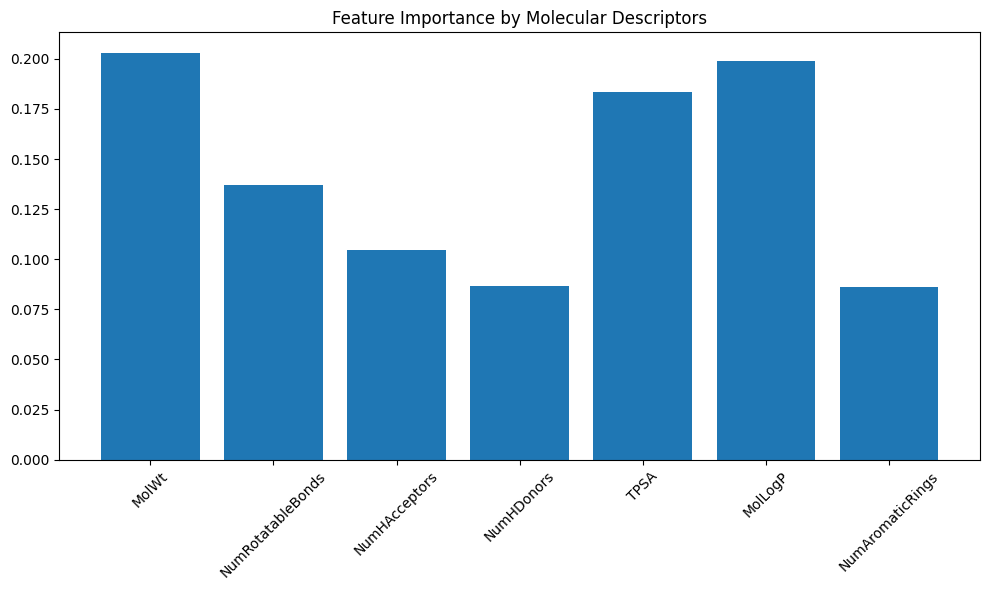

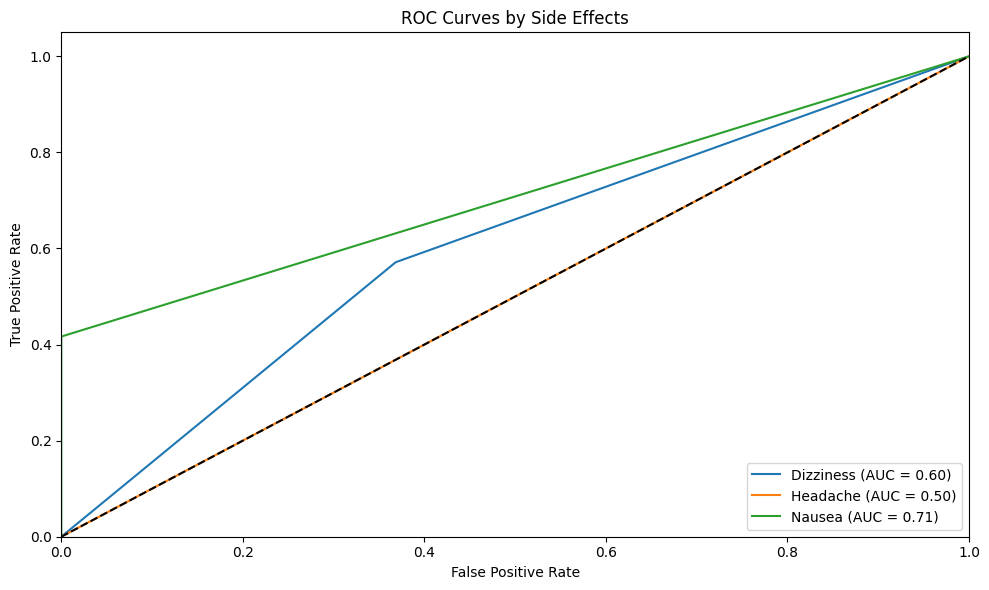

In [ ]:
# 모델 훈련
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# 멀티라벨 분류를 위한 모델 생성
base_rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
model = MultiOutputClassifier(base_rf)

# 모델 훈련
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
from sklearn.metrics import hamming_loss, multilabel_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
print(f'Hamming Loss: {hamming_loss(y_test, y_pred)}')

# 각 클래스별 성능 메트릭 계산
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f'\n전체 성능 메트릭 (macro average):')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')

# 각 부작용별 혼동 행렬 계산
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)
side_effect_names = ['Dizziness', 'Headache', 'Nausea']

# 각 부작용별 성능 출력
for i, side_effect in enumerate(side_effect_names):
    tn, fp, fn, tp = conf_matrices[i].ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f'\n{side_effect} 성능:')
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1-score: {f1:.3f}')

# Feature importance visualization
plt.figure(figsize=(10, 6))
feature_importance = np.mean([estimator.feature_importances_
                            for estimator in model.estimators_], axis=0)
descriptor_names = ['MolWt', 'NumRotatableBonds', 'NumHAcceptors',
                   'NumHDonors', 'TPSA', 'MolLogP', 'NumAromaticRings']

plt.bar(descriptor_names, feature_importance)
plt.xticks(rotation=45)
plt.title('Feature Importance by Molecular Descriptors')
plt.tight_layout()
plt.show()

# ROC curve plotting
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10, 6))

for i, side_effect in enumerate(side_effect_names):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{side_effect} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Side Effects')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()